In [88]:
import os 
import sys
import re
import time
import csv
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import ik_parsing as ik
import data_extraction as de
import helper_functions as hp
import defs
from datetime import datetime
from collections import defaultdict
import itertools
import zipfile
import gzip
import json
import concurrent.futures
from multiprocessing import Pool
import matplotlib.pyplot as plt
import math

head, tail = os.path.split(os.getcwd())

In [ ]:
import importlib
importlib.reload(ik)
importlib.reload(de)


if __name__ == '__main__':
    start = time.time()
    df = pd.DataFrame()
    courts = ['bombay', 'jharkhand', 'chattisgarh', 'jammu', 'andhra']
    dfs = []
#     pool = Pool()
#     results = pool.imap(de.extract_data, courts)      
                
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(de.extract_data, courts)

    for result in results:
        dfs.append(pd.DataFrame(result))

df = pd.concat(dfs)

# takes ~1506 seconds with 500 limit break; took ~3 hours or so for all of MH, JH and CH
print(f"--- {(time.time() - start)} seconds ---")  

print(df.shape)
df.head()

In [ ]:
df.reset_index(drop=True, inplace=True)
df['case_id'] = df['file'].apply(lambda x: x[x.rfind('/')+1:-4]) 

citation_counts = hp.citation_count_dict(df)

df['times_cited'] = df['case_id'].apply(lambda x: citation_counts.get(x, 0))

df['bench_size'] = df.loc[:,'judge'].dropna().apply(len)
        
df['num_citations'] = df.loc[:,'citations'].dropna().apply(len)

df['chief_justice'] = df.loc[:,'judge'].dropna().apply(lambda x: (any('chief' in item for item in x)))

keywords_state = ['state', 'government', 'commissioner', 'national', 'india', 'indian', 'public', 'magistrate',
                  'collector', 'department', 'district']
df['state'] = df.loc[:,'title'].dropna().apply(lambda x: (any(keyword in x.lower() for keyword in keywords_state)))

keywords_business = ['pvt', 'private', 'limited', 'ltd', 'company', 'co.', 'llp', 'llc']
df['business'] = (df.loc[:,'petitioner']+df.loc[:,'respondent']).dropna().apply(lambda x: (any(keyword in x.lower() for keyword in keywords_business)))

keywords_male = ['shri', 'mr.', 'master']

df.replace('\n', ' ', regex = True, inplace = True)
print(df.shape)
df.head()

The number of missing values. Try and get this to around 85-90% and above to proceed. Judges we are extracting at a reasonable accuracy. Next step is to optimize advocates but that is a lot more difficult. Will have to try NER or other approaches. 

We have parsed all the basic case data into the dataframe. Pickle it so that you dont need to run above code every time you start this notebook. Instead you can start from below on. 

In [4]:
df.isna().sum()

file                         0
cnr_num                2659779
title                    18517
date                     18517
court                    18517
case_number            2464034
petitioner             1086331
respondent             1086331
petitioner_advocate    2447338
respondent_advocate    2646699
judge                   109249
banks                  2645052
citations              1276958
bench_size              109249
num_citations          1276958
chief_justice           109249
state                    18517
business               1086331
case_id                      0
times_cited                  0
dtype: int64

In [ ]:
df.to_pickle('df_11courts.pkl')

In [66]:
df = pd.read_pickle('df_11courts.pkl')
df = df[df.court!='Gujarat High Court'].reset_index(drop=True)
df = df[~df.court.isna()]

In [67]:
print(df.court.value_counts())

Madras High Court              470761
Jharkhand High Court           338969
Allahabad High Court           228124
Bombay High Court              221571
Himachal Pradesh High Court    131476
Bangalore District Court        67788
Gauhati High Court              64640
Chattisgarh High Court          59361
Jammu & Kashmir High Court      36713
Andhra High Court               14263
Name: court, dtype: int64


In [68]:
df.groupby(df.date.dt.strftime('%Y')).size()

date
2000      3955
2001      4849
2002      8769
2003      8852
2004      8834
2005      8709
2006     12366
2007     12582
2008      9966
2009     12191
2010     83620
2011     45764
2012     49289
2013     39700
2014     67325
2015    155688
2016    146459
2017    203641
2018    282016
2019    469091
dtype: int64

In [69]:
upload_dates = {'Gujarat High Court': datetime.strptime('2010-06-13', '%Y-%m-%d').date(),
                'Jharkhand High Court': datetime.strptime('2010-06-13', '%Y-%m-%d').date(),
                'Himachal Pradesh High Court': datetime.strptime('2017-04-15', '%Y-%m-%d').date(),
                'Allahabad High Court': datetime.strptime('2010-07-18', '%Y-%m-%d').date(),
                'Bangalore District Court': datetime.strptime('2017-02-01', '%Y-%m-%d').date(),
                'Madras High Court': datetime.strptime('2009-01-18', '%Y-%m-%d').date(),
                'Bombay High Court': datetime.strptime('2009-01-18', '%Y-%m-%d').date(),
                'Gauhati High Court': datetime.strptime('2009-01-18', '%Y-%m-%d').date() ,
                'Chattisgarh High Court': datetime.strptime('2009-01-18', '%Y-%m-%d').date(),
                'Jammu & Kashmir High Court': datetime.strptime('2009-01-18', '%Y-%m-%d').date(),
                'Andhra High Court': datetime.strptime('2009-01-18', '%Y-%m-%d').date(),
               }

df['ik_rollout'] = df['court'].apply(lambda x: upload_dates.get(x, np.nan))
df.ik_rollout = pd.to_datetime(df.ik_rollout)
df.loc[:,'days_to_update'] = (df.loc[:, 'date'] - df.loc[:, 'ik_rollout'])
df.loc[:,'days_to_update'] = df.loc[:,'days_to_update'].astype('timedelta64[D]')
df.loc[df.days_to_update>0,'days_to_update'] = 0
df.loc[:,'months_to_update'] = (df.loc[:,'days_to_update']/30).apply(math.floor)

In [116]:
# Create a dictionary where the key is a caseid that was uploaded on IK after its hearing date (not in realtime)
# and the value is the date it was uploaded
cases_prior = df.loc[df.months_to_update<0,['case_id','ik_rollout']].set_index('case_id').to_dict()['ik_rollout']

In [103]:
df.loc[df.months_to_update<0,'times_cited'].sum()

63738

In [114]:
df.loc[df.months_to_update<0,:].groupby('court').size()

court
Allahabad High Court           50149
Andhra High Court               9840
Bangalore District Court       44410
Bombay High Court              11547
Chattisgarh High Court          1090
Gauhati High Court              3322
Himachal Pradesh High Court     6860
Jammu & Kashmir High Court      1813
Jharkhand High Court           11151
Madras High Court              30884
dtype: int64

In [186]:
res_dict = defaultdict(int)

for row in df.itertuples():
#     print(row)
    if str(row.citations)!='nan':
        for citation in row.citations:
            if citation in cases_prior:
                res_dict[round((row.date-cases_prior[citation]).days/30)] += 1
    #             print(citation, (row.date-cases_prior[citation]).days)
    #     break
    

In [187]:
res_dict

defaultdict(int,
            {-105: 83,
             -106: 97,
             -109: 134,
             -103: 202,
             -100: 178,
             -107: 130,
             -102: 200,
             -108: 151,
             -101: 143,
             -118: 6,
             -104: 164,
             -99: 211,
             -110: 73,
             -127: 39,
             -126: 51,
             -125: 41,
             -128: 44,
             -98: 125,
             -124: 47,
             -208: 1,
             -120: 55,
             -90: 288,
             -86: 181,
             -88: 238,
             -114: 28,
             -96: 233,
             -89: 278,
             -91: 264,
             -97: 247,
             -92: 270,
             -95: 249,
             -87: 233,
             -94: 175,
             -93: 152,
             -113: 19,
             -112: 21,
             -78: 306,
             -74: 167,
             -80: 280,
             -79: 318,
             -85: 236,
             -76: 263,
           

In [188]:
df_es = pd.DataFrame({'days':list(res_dict.keys()), 'num_citations':list(res_dict.values())})

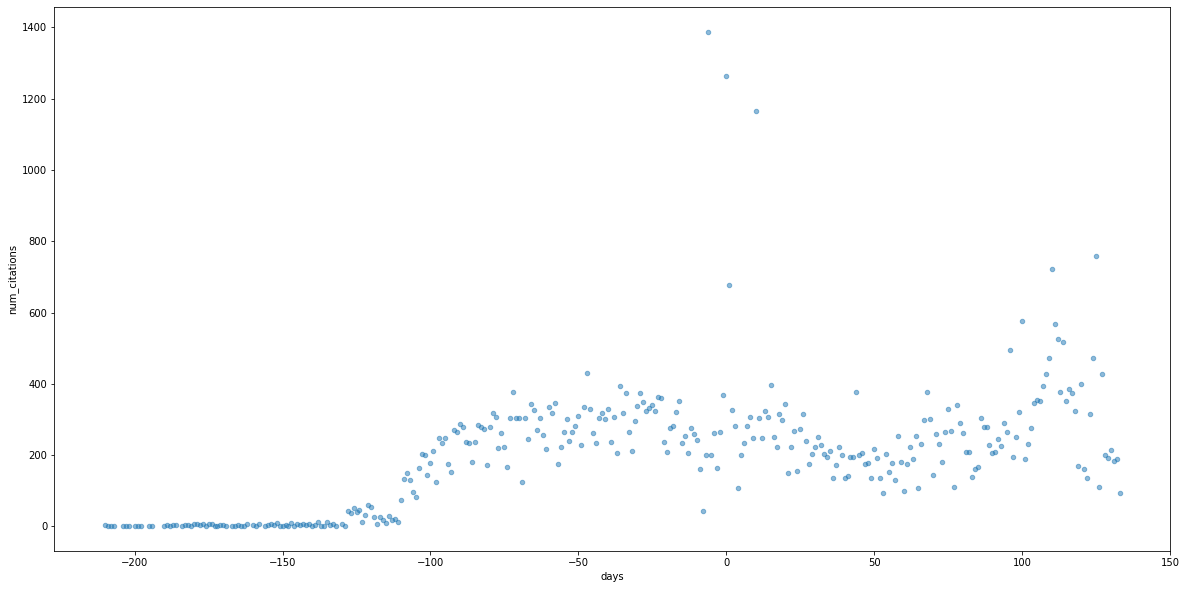

In [192]:
# df_es.set_index('index', inplace=True)
df_es.plot(x='days', y='num_citations', kind='scatter', figsize=(20,10), alpha=0.5)

In [182]:
df_es.groupby('days')

In [193]:
import numpy as np
import pandas as pd
df=pd.DataFrame({'A':np.random.random(20),'B':np.random.random(20)})

In [194]:
df

,A,B
0,0.152690,0.005456
1,0.439009,0.952405
2,0.103124,0.788470
3,0.985292,0.034172
4,0.619244,0.332357
5,0.563839,0.618220
6,0.913253,0.438238
7,0.948744,0.749939
8,0.151996,0.434413
9,0.966744,0.728472


In [197]:
df = df.sort_values('B')
df
bins =  np.arange(0,1.0,0.155)
ind = np.digitize(df['B'],bins)

# print df.groupby(ind).head()

array([0.   , 0.155, 0.31 , 0.465, 0.62 , 0.775, 0.93 ])